## Question 1

In [2]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import sympy as sp

In [3]:
df = pd.read_csv("Kinetics.csv")
S1 = df["S1"].to_numpy(dtype=float)
S2 = df["S2"].to_numpy(dtype=float)
vlt = df["Rate"].to_numpy(dtype=float)

# assume constant sigma for chi-square scaling
sigma = np.full_like(vlt, fill_value = np.std(vlt)*0.02)
sigma = np.where(sigma <= 0, 1.0, sigma)

In [4]:
def pingpong_bibi(params, s1, s2):
    """ 
    v = Vmax * s1 * s2 / (Km2 * s1 + Km1 * s2 + s1 * s2)
    params = [Vmax, Km1, Km2]
    """
    Vmax, Km1, Km2 = params
    num = Vmax * s1 * s2 
    den = Km2 * s1 + Km1 * s2 + s1 * s2
    return num / den

def sequential_type1a(params, s1, s2):
    """
    v = Vmax * s1 * s2 / (Kis1 * Km1 + Km1 * s1 + s1 * s2)
    params = [Vmax, Km1, Kis1]
    """
    Vmax, Km1, Kis1 = params
    num = Vmax * s1 * s2
    den = Kis1 * Km1 + Km1 * s1 + s1 * s2
    return num / den

def sequential_type1b(params, s1, s2):
    """
    v = Vmax * s1 * s2 / (Kis1 * Km1 + Km1 * s1 + Km2 * s2 + s1 * s2)
    params = [Vmax, Km1, Km2, Kis1]
    """
    Vmax, Km1, Km2, Kis1 = params
    num = Vmax * s1 * s2
    den = Kis1 * Km1 + Km1 * s1 + Km2 * s2 + s1 * s2
    return num / den

In [5]:
@dataclass
class FitResult:
    name: str
    params: np.ndarray
    success: bool
    r2: float
    chi2: float
    red_chi2: float

In [6]:
def r2_score(y, yhat):
    ss_res = np.sum((y-yhat)**2)
    ss_tot = np.sum((y-np.mean(y)) ** 2)
    return 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

def fit_model(model_fun, name, p0, bounds, s1, s2, v, sigma):
    """
    Weighted least squares fit using least_squares.
    Minimize sum(((v-model)/sigma)^2).
    """
    def residuals(p):
        return (v-model_fun(p,s1,s2))/sigma
    
    res = least_squares(residuals, x0=np.array(p0, dtype=float), bounds=bounds, method="trf")
    p_hat = res.x
    v_hat = model_fun(p_hat, s1, s2)

    chi2 = np.sum(((v-v_hat)/sigma)**2)
    dof = max(len(v) - len(p_hat), 1)
    red_chi2 = chi2 / dof 
    r2 = r2_score(v, v_hat)

    return FitResult(
        name = name,
        params = p_hat,
        success = res.success,
        r2 = r2,
        chi2 = chi2,
        red_chi2 = red_chi2,
    )

In [7]:
# Initial guess
Vmax0 = np.max(vlt)
Km10 = np.median(S1)
Km20 = np.median(S2)
Kis10 = Km10

# Enforce positivity for kinetic constants
pos_low = 1e-12

fits = []

# Ping-pong
fits.append(
    fit_model(
        pingpong_bibi,
        "PingPong",
        p0 = [Vmax0, Km10, Km20],
        bounds = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Sequantial type 1a
fits.append(
    fit_model(
        sequential_type1a,
        "Sequential type 1a",
        p0 = [Vmax0, Km10, Kis10],
        bounds = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Sequential type 1b 
fits.append(
    fit_model(
        sequential_type1b,
        "Sequential type 1b",
        p0 = [Vmax0, Km10, Km20, Kis10],
        bounds = ([pos_low, pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Print comparison
fits_sorted = sorted(fits, key = lambda fr: fr.red_chi2)
for fr in fits_sorted:
    print(f"\n==={fr.name}===")
    print("success  :", fr.success)
    print("params   :", fr.params)
    print("R^2      :", fr.r2)
    print("chi^2    :", fr.chi2)
    print("red chi^2:", fr.red_chi2)

best = fits_sorted[0]
print("\nBest by reduced chi-square:", best.name)


===PingPong===
success  : True
params   : [1.  0.1 0.1]
R^2      : 1.0
chi^2    : 1.2435069832463078e-25
red chi^2: 4.186892199482518e-28

===Sequential type 1b===
success  : True
params   : [9.99999990e-01 9.99999944e-02 9.99999942e-02 2.05561549e-08]
R^2      : 0.9999999999999994
chi^2    : 4.5459515716978655e-10
red chi^2: 1.5357944498979276e-12

===Sequential type 1a===
success  : True
params   : [0.78808214 0.03331481 0.59980728]
R^2      : 0.8095529965199977
chi^2    : 142835.25261000168
red chi^2: 480.9267764646521

Best by reduced chi-square: PingPong


Both ping-pong and sequential-random can fit the dataset nearly perfectly. However, the sequential-random fit collapses with Kis1≈0, indicating the extra term is not supported (parameter degeneracy).

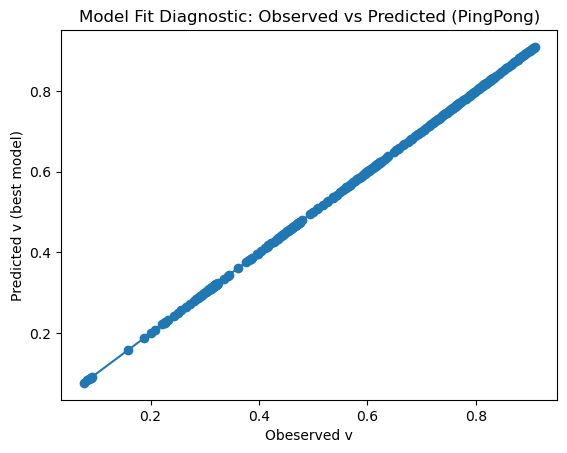

In [68]:
model_map = {
    "PingPong": pingpong_bibi,
    "Sequential type 1a": sequential_type1a,
    "Sequential type 1b": sequential_type1b,
}

best_fun = model_map[best.name]
v_best = best_fun(best.params, S1, S2)

plt.figure()
plt.scatter(vlt, v_best)
mn,mx = min(vlt.min(), v_best.min()), max(vlt.max(), v_best.max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Obeserved v")
plt.ylabel("Predicted v (best model)")
plt.title(f"Model Fit Diagnostic: Observed vs Predicted ({best.name})")
plt.show()

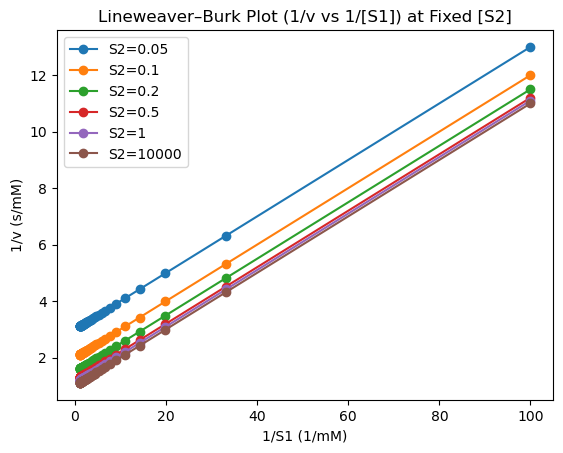

In [69]:
for s2_val, sub in df.groupby("S2"):
    sub = sub.sort_values("S1")
    x = 1.0 / sub["S1"].to_numpy()
    y = 1.0 / sub["Rate"].to_numpy()
    plt.plot(x, y, marker = "o", linestyle = "-", label = f"S2={s2_val:g}")

plt.xlabel("1/S1 (1/mM)")
plt.ylabel("1/v (s/mM)")
plt.title("Lineweaver–Burk Plot (1/v vs 1/[S1]) at Fixed [S2]")
plt.legend()
plt.show()

In [19]:
# Stochastic results: bootstrap parameter distributions
def bootstrap_fit(model_fun, name, p0, bounds, s1, s2, v, sigma, B =1000, seed = 0):
    """
    Nonparametric bootstrap: resample rows with replacement, refit each time.
    Returns array of shape (B, n_params).
    """
    rng = np.random.default_rng(seed)
    n = len(v)
    n_params = len(p0)
    samples = np.zeros((B,n_params), dtype=float)
    ok = np.zeros(B, dtype=bool)
    for b in range(B):
        idx = rng.integers(0, n, size = n)
        s1b, s2b, vb, sigb = s1[idx], s2[idx], v[idx], sigma[idx]

        fr = fit_model(model_fun, name, p0, bounds, s1b, s2b, vb, sigb)
        samples[b,:] = fr.params
        ok[b] = fr.success
    
    return samples, ok

if best.name == "PingPong":
    p0_best = [Vmax0, Km10, Km20]
    bounds_best = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf])
elif best.name == "Sequential type 1a":
    p0_best = [Vmax0, Km10, Kis10]
    bounds_best = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf])
else:
    p0_best = [Vmax0, Km10, Km20, Kis10]
    bounds_best = ([pos_low, pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf, np.inf])

samples, ok = bootstrap_fit(best_fun, best.name, p0_best, bounds_best, S1, S2, vlt, sigma, B=1000, seed=42)
samples_ok = samples[ok]

print(f"\nBootstrap success rate: {ok.mean():.3f} (kept {samples_ok.shape[0]} fits)")

# Summaries (95% CI)
param_names = {
    "PingPong": ["Vmax", "Km1", "Km2"],
    "Sequential type 1a": ["Vmax", "Km1", "Kis1"],
    "Sequential type 1b": ["Vmax", "Km1", "Km2", "Kis1"],
}[best.name]

for j, nm in enumerate(param_names):
    vals = samples_ok[:, j]
    lo, med, hi = np.percentile(vals, [2.5, 50, 97.5])
    print(f"{nm:>5s}: median={med:.6g}, 95% CI=({lo:.6g}, {hi:.6g})")



Bootstrap success rate: 1.000 (kept 1000 fits)
 Vmax: median=1, 95% CI=(1, 1)
  Km1: median=0.1, 95% CI=(0.1, 0.1)
  Km2: median=0.1, 95% CI=(0.1, 0.1)


In [11]:
MW = 150.0  # g/mol
S0_gL = 100.0
Sf_gL = 1.0

Vmax = 1.0  # mM/s
Km = 0.1    # mM

# Convert g/L -> mM
S0_mM = (S0_gL / MW) * 1000.0
Sf_mM = (Sf_gL / MW) * 1000.0

# Integrated Michaelis–Menten batch time:
# t = (S0 - Sf)/Vmax + (Km/Vmax)*ln(S0/Sf)
t_sec = (S0_mM - Sf_mM) / Vmax + (Km / Vmax) * np.log(S0_mM / Sf_mM)

print("S0 (mM):", S0_mM)
print("Sf (mM):", Sf_mM)
print("Time (s):", t_sec)
print("Time (min):", t_sec / 60.0)


S0 (mM): 666.6666666666666
Sf (mM): 6.666666666666667
Time (s): 660.4605170185988
Time (min): 11.007675283643314


## Question 2 

## b.

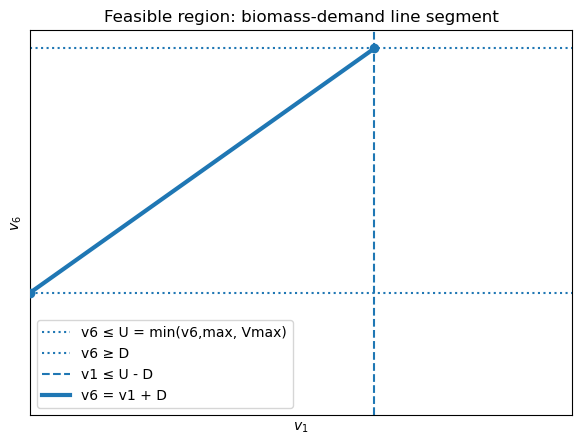

In [ ]:
# arbitrary values to make plot
v6_max = 5.0   # v_{6,max}
Vmax   = 3.0   # V_max from MM kinetics (cap on v6)
D      = 1.0   # biomass demand v9 = D
U = min(v6_max, Vmax)

v1 = np.linspace(0, U-D, 400)

plt.figure(figsize=(7, 5))

# Boundary lines
plt.axhline(U,      linestyle=":",  label="v6 ≤ U = min(v6,max, Vmax)")
plt.axhline(D,      linestyle=":",  label="v6 ≥ D")
if D <= U:
    v1_max = U - D
    plt.axvline(v1_max, linestyle="--", label=f"v1 ≤ U - D")


v1_line = np.linspace(0, U, 400)
v6_line = v1_line + D

ok = (v1_line >= 0) & (v1_line <= U-D) & (v6_line <= U) & (v6_line >= D)

if np.any(ok):
    plt.plot(v1_line[ok], v6_line[ok], linewidth=3, label="v6 = v1 + D")
    v1_lo, v1_hi = v1_line[ok][0], v1_line[ok][-1]
    plt.scatter([v1_lo, v1_hi], [v1_lo + D, v1_hi + D], zorder=5)
    plt.title("Feasible region: biomass-demand line segment")


plt.xlim(0, U * 1.05 if U > 0 else 1)
plt.ylim(0, U * 1.05 if U > 0 else max(D, 1) * 1.05)
plt.xlabel(r"$v_1$")
plt.ylabel(r"$v_6$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.show()



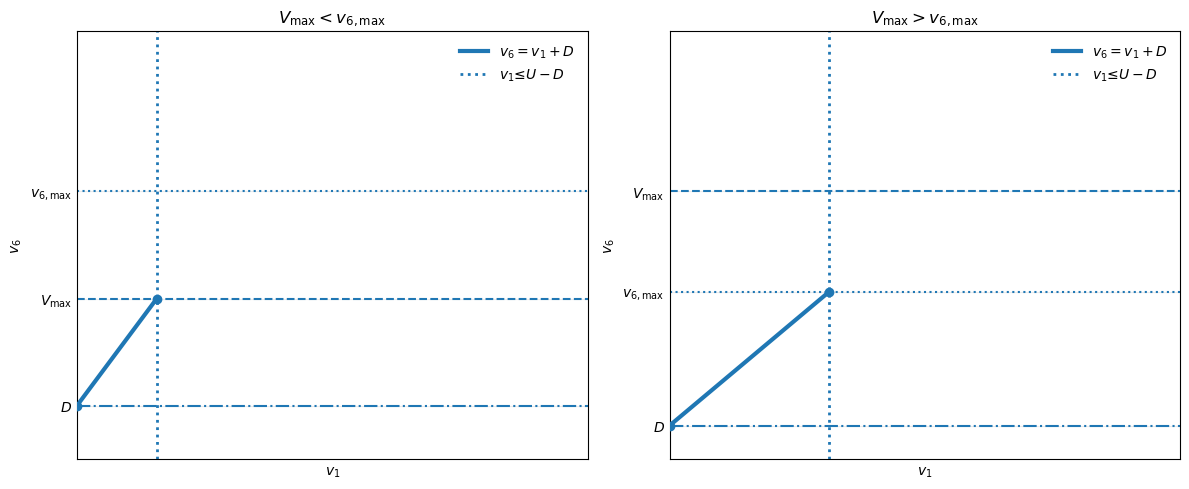

In [71]:
def plot_vmax_vs_v6max_side_by_side_separate_y(v6_max, D, Vmax_small, Vmax_big, n=300):

    def segment(U):
        if U < D:
            return None
        v1 = np.linspace(0, U - D, n)
        v6 = v1 + D
        return v1, v6

    def set_y_ticks(ax, D, Vmax_val, v6_max):
        yvals = sorted(set([D, Vmax_val, v6_max]))
        ylabels = []
        for y in yvals:
            if np.isclose(y, D):
                ylabels.append(r"$D$")
            elif np.isclose(y, Vmax_val):
                ylabels.append(r"$V_{\max}$")
            elif np.isclose(y, v6_max):
                ylabels.append(r"$v_{6,\max}$")
            else:
                ylabels.append(f"{y:g}")
        ax.set_yticks(yvals)
        ax.set_yticklabels(ylabels)
        ax.tick_params(axis="y", which="major", length=0)

    U_small = min(v6_max, Vmax_small)
    U_big   = min(v6_max, Vmax_big)

    seg_small = segment(U_small)
    seg_big   = segment(U_big)

    # NOTE: sharey=False gives separate y-axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=False)

    cases = [
        (axes[0], U_small, seg_small, r"$V_{\max}<v_{6,\max}$", Vmax_small),
        (axes[1], U_big,   seg_big,   r"$V_{\max}>v_{6,\max}$", Vmax_big),
    ]

    for ax, U, seg, title, Vmax_val in cases:
        ax.set_title(title)

        if seg is None:
            ax.text(0.05, 0.9, r"No feasible solution ($U < D$)",
                    transform=ax.transAxes)
        else:
            v1, v6 = seg
            ax.plot(v1, v6, linewidth=3, label=r"$v_6=v_1+D$")
            ax.scatter([v1[0], v1[-1]], [v6[0], v6[-1]], zorder=5)
            ax.axvline(U - D, linestyle=":", linewidth=2, label=r"$v_1 ≤ U-D$")

        # horizontal reference lines
        ax.axhline(v6_max,  linestyle=":",  linewidth=1.5)
        ax.axhline(Vmax_val, linestyle="--", linewidth=1.5)
        ax.axhline(D,       linestyle="-.", linewidth=1.5)

        # y-axis ticks/labels for THIS panel
        set_y_ticks(ax, D=D, Vmax_val=Vmax_val, v6_max=v6_max)

        ax.set_xlabel(r"$v_1$")
        ax.set_ylabel(r"$v_6$")   # each subplot has its own y-axis label
        ax.set_xticks([])
        ax.grid(True, alpha=0.25)
        ax.legend(frameon=False, loc="upper right")

        # panel-specific limits
        ymax = max(U, v6_max, Vmax_val, D, 1.0)
        ax.set_xlim(0, ymax * 1.6)
        ax.set_ylim(0, ymax * 1.6)

    fig.tight_layout()
    plt.show()


# example
v6_max = 5.0
D = 1.0
Vmax_small = 3.0
Vmax_big   = 8.0

plot_vmax_vs_v6max_side_by_side_separate_y(v6_max, D, Vmax_small, Vmax_big)


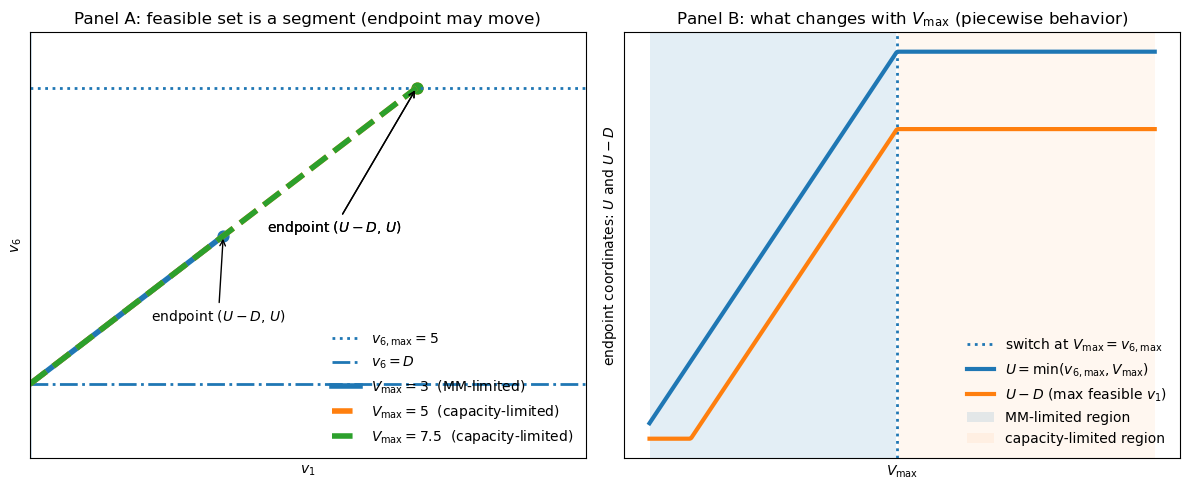

In [67]:
def plot_vmax_effect_clear(v6_max, D, Vmax_grid, n=200):
    """
    Clear visualization of:
      - When Vmax is tight (Vmax < v6_max): increasing Vmax expands feasible segment
      - When v6_max is tight (Vmax >= v6_max): increasing Vmax doesn't change feasible segment

    Feasible set (with v9 = D):
      v6 = v1 + D
      0 <= v1 <= U - D
      U = min(v6_max, Vmax)
    """

    def segment_end(U):
        # segment from (0,D) to (U-D, U), exists iff U>=D
        if U < D:
            return None
        return (0.0, D), (U - D, U)

    Vmax_grid = np.asarray(Vmax_grid, float)
    U_grid = np.minimum(v6_max, Vmax_grid)

    # --- Panel A: geometry in (v1, v6) for three representative Vmax values
    # pick: one MM-limited, one at the switch, one capacity-limited
    Vmax_a = min(np.max(Vmax_grid), 0.6 * v6_max)
    Vmax_b = v6_max
    Vmax_c = 1.5*v6_max
    reps = [Vmax_a, Vmax_b, Vmax_c]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ----- Panel A: plot segments and show which endpoint moves
    ax1.axhline(v6_max, linestyle=":", linewidth=2, label=rf"$v_{{6,\max}}={v6_max:g}$")
    ax1.axhline(D, linestyle="-.", linewidth=2, label=r"$v_6=D$")
    ax1.axvline(0, linewidth=1)

    for Vmax in reps:
        U = min(v6_max, Vmax)
        ends = segment_end(U)
        if ends is None:
            continue
        (x0,y0),(x1,y1) = ends
        mm_limited = (Vmax < v6_max)
        style = "-" if mm_limited else "--"
        label = (rf"$V_{{\max}}={Vmax:.2g}$  "
                 + (r"(MM-limited)" if mm_limited else r"(capacity-limited)"))

        ax1.plot([x0,x1], [y0,y1], linestyle=style, linewidth=4, label=label)
        ax1.scatter([x1], [y1], s=60)

        # annotate endpoint movement
        ax1.annotate(r"endpoint $(U-D,\,U)$",
                     xy=(x1,y1), xytext=(x1*0.6+0.05, y1*0.6+0.05),
                     arrowprops=dict(arrowstyle="->", lw=1))

    ax1.set_title(r"Panel A: feasible set is a segment (endpoint may move)")
    ax1.set_xlabel(r"$v_1$")
    ax1.set_ylabel(r"$v_6$")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(True, alpha=0.25)
    ax1.legend(frameon=False, loc="lower right")

    # set limits
    maxU = max(np.max(U_grid), D, 1.0)
    ax1.set_xlim(0, maxU * 1.15)
    ax1.set_ylim(0, maxU * 1.15)

    # ----- Panel B: 1D “effect” plot: endpoint coordinate vs Vmax
    # Endpoint is (U-D, U) when U>=D. Show U and U-D as functions of Vmax.
    ax2.axvline(v6_max, linestyle=":", linewidth=2, label=r"switch at $V_{\max}=v_{6,\max}$")

    ax2.plot(Vmax_grid, U_grid, linewidth=3, label=r"$U=\min(v_{6,\max},V_{\max})$")
    ax2.plot(Vmax_grid, np.maximum(U_grid - D, 0.0), linewidth=3, label=r"$U-D$ (max feasible $v_1$)")

    # visually mark the two regimes
    ax2.fill_between(Vmax_grid, 0, 1, where=(Vmax_grid < v6_max), alpha=0.12,
                     transform=ax2.get_xaxis_transform(), label="MM-limited region")
    ax2.fill_between(Vmax_grid, 0, 1, where=(Vmax_grid >= v6_max), alpha=0.06,
                     transform=ax2.get_xaxis_transform(), label="capacity-limited region")

    ax2.set_title(r"Panel B: what changes with $V_{\max}$ (piecewise behavior)")
    ax2.set_xlabel(r"$V_{\max}$")
    ax2.set_ylabel(r"endpoint coordinates: $U$ and $U-D$")
    ax2.grid(True, alpha=0.25)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.legend(frameon=False, loc="lower right")

    fig.tight_layout()
    plt.show()


# Example
v6_max = 5.0
D = 1.0
Vmax_grid = np.linspace(0.2, 10.0, 400)

plot_vmax_effect_clear(v6_max=v6_max, D=D, Vmax_grid=Vmax_grid)


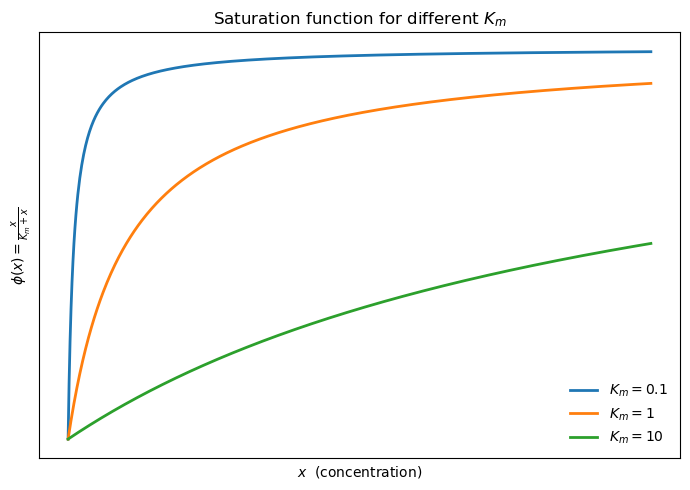

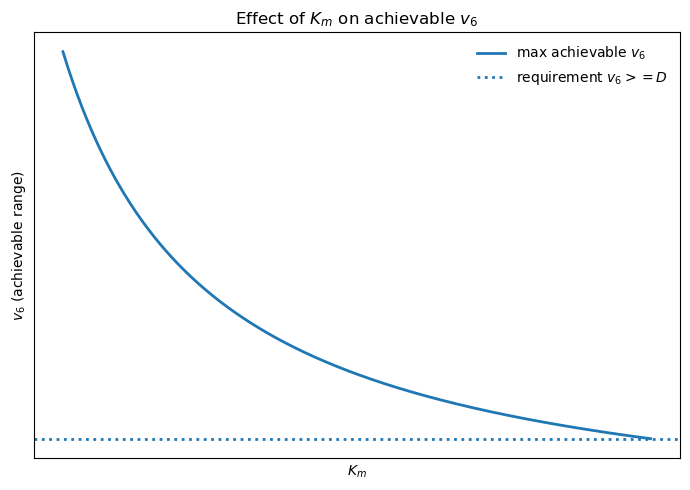

In [72]:
def plot_km_saturation_curves(Km_list, x_max=10.0, n=600):
    x = np.linspace(0.0, x_max, n)

    plt.figure(figsize=(7, 5))
    for Km in Km_list:
        phi = x / (Km + x)
        plt.plot(x, phi, linewidth=2, label=rf"$K_m={Km:g}$")

    plt.xlabel(r"$x$  (concentration)")
    plt.ylabel(r"$\phi(x)=\frac{x}{K_m+x}$")
    plt.title(r"Saturation function for different $K_m$")
    plt.grid(True, alpha=0.25)
    plt.xticks([])
    plt.yticks([])
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


def plot_km_effect_on_v6(Vmax, D, SUC_max, FUM_max, Km_grid):
    Km_grid = np.asarray(Km_grid, dtype=float)

    term_suc = SUC_max / (Km_grid + SUC_max)
    term_fum = FUM_max / (Km_grid + FUM_max)
    v6_max_ach = Vmax * (term_suc - 0.0)

    plt.figure(figsize=(7, 5))
    plt.plot(Km_grid, v6_max_ach, linewidth=2, label=r"max achievable $v_6$")
    plt.axhline(D, linestyle=":", linewidth=2, label=r"requirement $v_6 >= D$")

    plt.xlabel(r"$K_m$")
    plt.ylabel(r"$v_6$ (achievable range)")
    plt.title(r"Effect of $K_m$ on achievable $v_6$")
    plt.grid(True, alpha=0.25)
    plt.xticks([])
    plt.yticks([])
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


Km_list_for_phi = [0.1, 1.0, 10.0]
plot_km_saturation_curves(Km_list_for_phi, x_max=10.0)

Vmax = 5.0
D = 1.0
SUC_max = 5.0
FUM_max = 5.0
Km_grid = np.linspace(0.01, 20.0, 500)

plot_km_effect_on_v6(Vmax=Vmax, D=D, SUC_max=SUC_max, FUM_max=FUM_max, Km_grid=Km_grid)

